In [37]:
import pandas as pd
from sklearn.decomposition import PCA
import torch

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [39]:
df=pd.read_csv(f'dataset\GUIDE_Train\GUIDE_Train.csv',low_memory=False)

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9516837 entries, 0 to 9516836
Data columns (total 45 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Id                  int64  
 1   OrgId               int64  
 2   IncidentId          int64  
 3   AlertId             int64  
 4   Timestamp           object 
 5   DetectorId          int64  
 6   AlertTitle          int64  
 7   Category            object 
 8   MitreTechniques     object 
 9   IncidentGrade       object 
 10  ActionGrouped       object 
 11  ActionGranular      object 
 12  EntityType          object 
 13  EvidenceRole        object 
 14  DeviceId            int64  
 15  Sha256              int64  
 16  IpAddress           int64  
 17  Url                 int64  
 18  AccountSid          int64  
 19  AccountUpn          int64  
 20  AccountObjectId     int64  
 21  AccountName         int64  
 22  DeviceName          int64  
 23  NetworkMessageId    int64  
 24  EmailClusterId      floa

In [41]:
result=df

In [42]:
# def check_missing_values(df1, threshold_percentage=0.2):
#     columns_to_drop = set()

#     nan_counts = df1.isnull().mean()
#     nan_columns = nan_counts[nan_counts > threshold_percentage]
#     for col, percent in nan_columns.items():
#         print(f"Column '{col}' has {percent:.2%} missing values.")
#         columns_to_drop.add(col)

#     empty_str_count = (df1 == '').mean()
#     empty_str_columns = empty_str_count[empty_str_count > threshold_percentage]
#     for col, percent in empty_str_columns.items():
#         print(f"Column '{col}' has {percent:.2%} empty string values.")
#         columns_to_drop.add(col)

#     space_only_count = (df1.applymap(lambda x: isinstance(x, str) and x.isspace())).mean()
#     space_only_columns = space_only_count[space_only_count > threshold_percentage]
#     for col, percent in space_only_columns.items():
#         print(f"Column '{col}' has {percent:.2%} space-only values.")
#         columns_to_drop.add(col)

#     problematic_values = ['N/A', 'NA', 'null', 'NULL']
#     for value in problematic_values:
#         problematic_count = (df1 == value).mean()
#         problematic_columns = problematic_count[problematic_count > threshold_percentage]
#         for col, percent in problematic_columns.items():
#             print(f"Column '{col}' has {percent:.2%} '{value}' values.")
#             columns_to_drop.add(col)

#     return df1
# result = check_missing_values(result)


In [43]:
df['LastVerdict']=df['LastVerdict'].fillna('No Verdict')

In [44]:
print((df['LastVerdict'] == 'DomainPII_50d8b4a941c26b89482c94ab324b5a274f9ced66').sum())
print((df['LastVerdict'] == 'DomainPII_9207384283ce115db5a590dd9ca5de21e5e99df2').sum())

128
63


In [45]:
df.drop(columns=['ActionGrouped','ActionGranular','EmailClusterId','ThreatFamily','AntispamDirection','SuspicionLevel','Roles','ResourceType'],inplace=True)

In [46]:
categorical_df = df.select_dtypes(include=['object'])

In [47]:
# import pandas as pd
# import scipy.stats as stats

# categorical_columns = categorical_df.columns
# categorical_df[categorical_columns] = categorical_df[categorical_columns].fillna('Missing')

# def chi_square_test(column, target):
#     contingency_table = pd.crosstab(categorical_df[column], categorical_df[target])
#     chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
#     return chi2, p, dof

# results = {}
# for column in categorical_columns:
#     chi2, p, dof = chi_square_test(column, 'IncidentGrade')
#     results[column] = {'Chi-Square': chi2, 'P-Value': p, 'Degrees of Freedom': dof}

# # Display results
# results_categorical_df = pd.DataFrame(results).T
# print(results_categorical_df)


In [48]:
df.drop(columns=['Timestamp','MitreTechniques'],inplace=True)

In [49]:
df['Category'].unique()

array(['InitialAccess', 'Exfiltration', 'CommandAndControl', 'Execution',
       'SuspiciousActivity', 'Impact', 'Collection', 'CredentialAccess',
       'Persistence', 'Discovery', 'Malware', 'DefenseEvasion', 'Exploit',
       'PrivilegeEscalation', 'LateralMovement', 'Ransomware',
       'UnwantedSoftware', 'CredentialStealing', 'WebExploit',
       'Weaponization'], dtype=object)

In [50]:
df['EntityType'].unique()

array(['Ip', 'User', 'Url', 'MailMessage', 'Process', 'Machine',
       'CloudApplication', 'AzureResource', 'File', 'Mailbox',
       'CloudLogonRequest', 'MailCluster', 'Malware', 'CloudLogonSession',
       'OAuthApplication', 'RegistryValue', 'SecurityGroup',
       'RegistryKey', 'GenericEntity', 'ActiveDirectoryDomain',
       'BlobContainer', 'Blob', 'MailboxConfiguration', 'IoTDevice',
       'AmazonResource', 'Nic', 'Container', 'GoogleCloudResource',
       'KubernetesCluster', 'ContainerImage', 'KubernetesNamespace',
       'KubernetesPod', 'ContainerRegistry'], dtype=object)

In [51]:
df['EvidenceRole'].unique()

array(['Related', 'Impacted'], dtype=object)

In [52]:
df['LastVerdict'].unique()

array(['No Verdict', 'Suspicious', 'Malicious', 'NoThreatsFound',
       'DomainPII_50d8b4a941c26b89482c94ab324b5a274f9ced66',
       'DomainPII_9207384283ce115db5a590dd9ca5de21e5e99df2'], dtype=object)

In [53]:
valid_verdicts = ['No Verdict', 'Suspicious', 'Malicious', 'NoThreatsFound']
df = df[df['LastVerdict'].isin(valid_verdicts)]

In [54]:
df = df.dropna()
df.reset_index(drop=True, inplace=True)

In [55]:
from sklearn.preprocessing import LabelEncoder
import joblib

label_encoder = LabelEncoder()
columns_to_encode = ['Category', 'EntityType','EvidenceRole','LastVerdict','IncidentGrade' ]

for column in columns_to_encode:
    df[column] = label_encoder.fit_transform(df[column])
    
    joblib.dump(label_encoder, f'models/{column}_label_encoder.pkl')


In [56]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_df.corr()

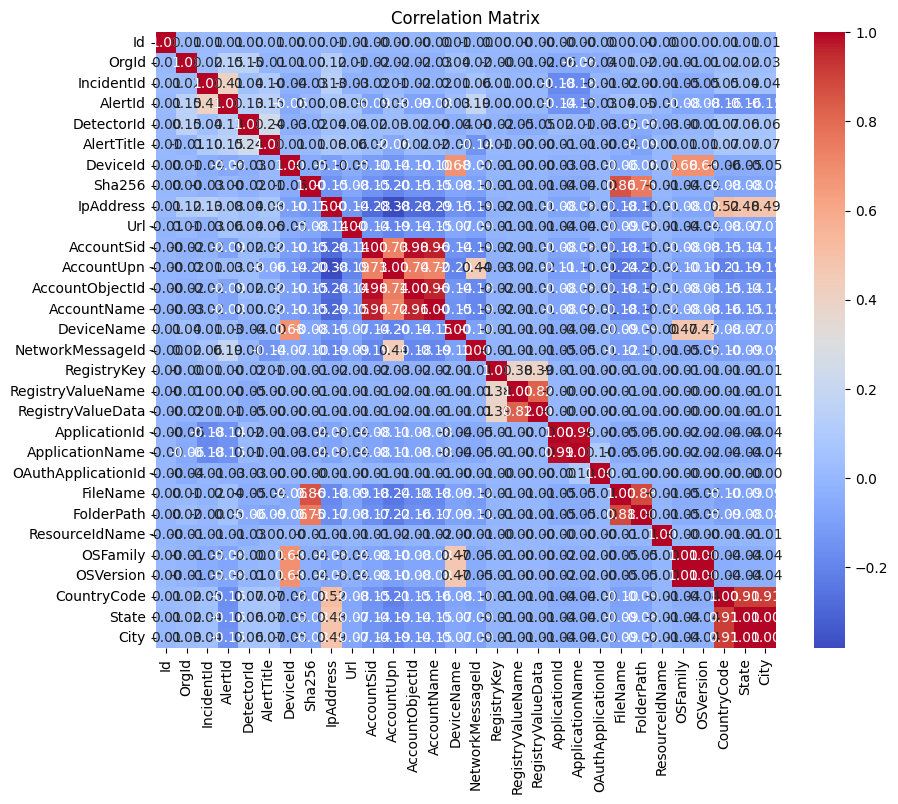

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Correlation Matrix')
plt.show()

In [58]:
print(len(df['CountryCode'].unique()))
print(len(df['State'].unique()))
print(len(df['City'].unique()))

236
1368
9342


In [59]:
scaled_data=df[['CountryCode', 'State', 'City']]
pca = PCA(n_components=1)
df['location'] = pca.fit_transform(scaled_data)
joblib.dump(pca, 'models/location.pkl')

['models/location.pkl']

In [60]:
scaled_data=df[['AccountSid', 'AccountUpn', 'AccountObjectId','AccountName']]
pca = PCA(n_components=1)
df['Account'] = pca.fit_transform(scaled_data)
joblib.dump(pca, 'models/Account.pkl')

['models/Account.pkl']

In [61]:
scaled_data=df[['RegistryValueName', 'RegistryValueData']]
pca = PCA(n_components=1)
df['RegistryName'] = pca.fit_transform(scaled_data)
joblib.dump(pca, 'models/RegistryName.pkl')

['models/RegistryName.pkl']

In [62]:
scaled_data=df[['FileName','FolderPath','Sha256']]
pca = PCA(n_components=1)
df['Path'] = pca.fit_transform(scaled_data)
joblib.dump(pca, 'models/Path.pkl')

['models/Path.pkl']

In [63]:
df=df.drop(['CountryCode', 'State', 'City','OSVersion','ApplicationName','AccountSid', 'AccountUpn','Sha256', 'AccountObjectId','AccountName','RegistryValueName', 'RegistryValueData','FileName','FolderPath'],axis=1)

In [64]:
df.head()

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,...,RegistryKey,ApplicationId,OAuthApplicationId,ResourceIdName,OSFamily,LastVerdict,location,Account,RegistryName,Path
0,180388628218,0,612,123247,7,6,10,2,15,1,...,1631,2251,881,3586,5,1,10021.894100,-255793.506025,-0.516609,-30787.484763
1,455266534868,88,326,210035,58,43,7,1,32,0,...,1631,2251,881,3586,5,1,-704.135776,714445.647433,-0.516609,-30787.484763
2,1056561957389,809,58352,712507,423,298,10,1,31,1,...,1631,2251,881,3586,5,3,-704.135776,-255793.506027,-0.516609,-30787.484763
3,1279900258736,92,32992,774301,2,2,1,0,31,1,...,1631,2251,881,3586,5,3,-704.135776,-255793.506027,-0.516609,-30787.484763
4,214748368522,148,4359,188041,9,74,6,2,32,0,...,1631,2251,881,3586,5,1,-704.135776,758239.168151,-0.516609,-30787.484763


In [65]:
df.to_csv('b_scale.csv',index=False)

In [66]:
# import os
# import seaborn as sns
# import matplotlib.pyplot as plt



# def save_boxplots(df, folder_name='boxplots'):
 
#     numerical_cols = df.select_dtypes(include=['number']).columns

#     if not os.path.exists(folder_name):
#         os.makedirs(folder_name)

#     for col in numerical_cols:
#         plt.figure(figsize=(6, 6))
#         sns.boxplot(y=df[col])
#         plt.title(f"Box Plot - {col}")
#         plt.ylabel(col)
        
#         file_path = os.path.join(folder_name, f"{col}_boxplot.png")
#         plt.savefig(file_path)
#         plt.close()

#     print(f"All box plots saved to folder: {folder_name}")

# save_boxplots(df)


Original class distribution: Counter({0: 4110775, 2: 3322578, 1: 2031953})
Resampled class distribution: Counter({0: 2031953, 1: 2031953, 2: 2031953})


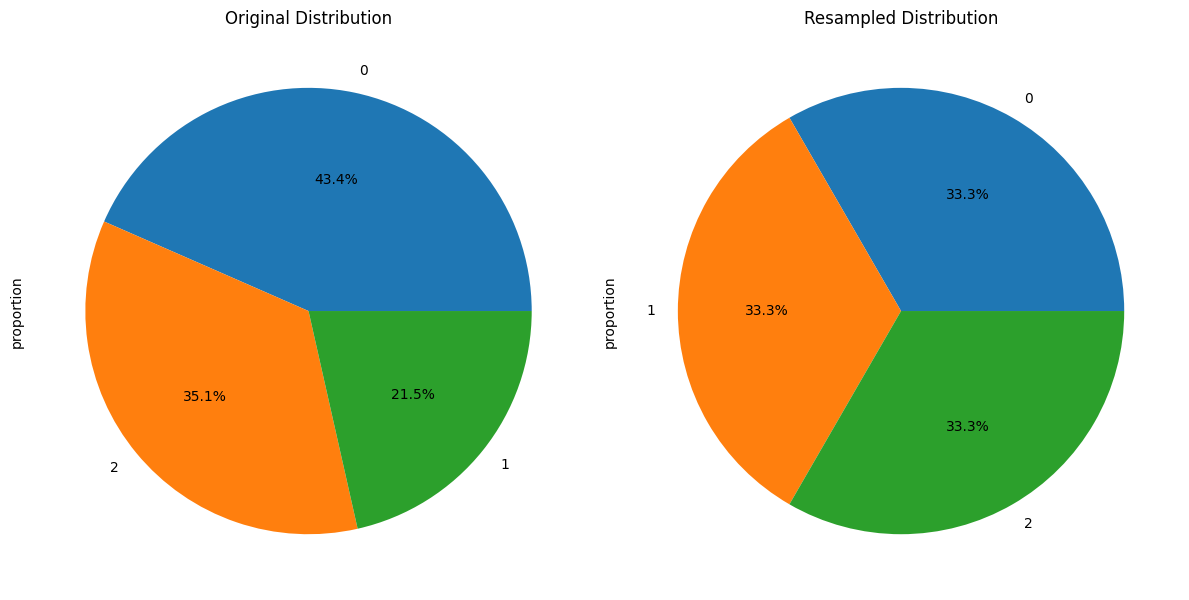

In [67]:
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter


X = df.drop('IncidentGrade', axis=1) 
y = df['IncidentGrade']

print("Original class distribution:", Counter(y))

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

print("Resampled class distribution:", Counter(y_resampled))

original_distribution = pd.Series(y).value_counts(normalize=True)

resampled_distribution = pd.Series(y_resampled).value_counts(normalize=True)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

original_distribution.plot.pie(autopct='%1.1f%%', labels=original_distribution.index, ax=ax[0], title="Original Distribution")

resampled_distribution.plot.pie(autopct='%1.1f%%', labels=resampled_distribution.index, ax=ax[1], title="Resampled Distribution")

plt.tight_layout()
plt.show()


In [68]:
X_resampled.reset_index(drop=True,inplace=True)

In [69]:
y_resampled.reset_index(drop=True,inplace=True)

In [ ]:
import pandas as pd

X_df = pd.DataFrame(X_resampled)

y_df = pd.DataFrame(y_resampled, columns=['IncidentGrade'])

df1 = pd.concat([X_df, y_df], axis=1)
df1.to_csv('bal_train.csv',index=False)


In [71]:
from sklearn.preprocessing import StandardScaler
import joblib

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

joblib.dump(scaler, 'models/scaler.pkl') 


['models/scaler.pkl']

In [72]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size=0.2, random_state=42)

In [73]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import classification_report, accuracy_score

# # Initialize the model
# model = LogisticRegression(max_iter=1000)
# model.fit(X_train, y_train)

# # Make predictions
# y_pred = model.predict(X_test)

# # Evaluate the model
# print(accuracy_score(y_test, y_pred))
# print(classification_report(y_test, y_pred))


In [74]:
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# lda = LinearDiscriminantAnalysis()
# lda.fit(X_train, y_train)
# y_pred_lda = lda.predict(X_test)
# print(accuracy_score(y_test, y_pred_lda))
# print(classification_report(y_test, y_pred_lda))


In [75]:
# from sklearn.linear_model import RidgeClassifier
# ridge = RidgeClassifier()
# ridge.fit(X_train, y_train)
# y_pred_ridge = ridge.predict(X_test)
# print(accuracy_score(y_test, y_pred_ridge))
# print(classification_report(y_test, y_pred_ridge))



In [76]:
# from sklearn.tree import DecisionTreeClassifier
# dt = DecisionTreeClassifier(random_state=42)
# dt.fit(X_train, y_train)
# y_pred_dt = dt.predict(X_test)
# print(accuracy_score(y_test, y_pred_dt))
# print(classification_report(y_test, y_pred_dt))



In [77]:
# from sklearn.ensemble import AdaBoostClassifier
# ada = AdaBoostClassifier(n_estimators=100, random_state=42)
# ada.fit(X_train, y_train)
# y_pred_ada = ada.predict(X_test)
# print(accuracy_score(y_test, y_pred_ada))
# print(classification_report(y_test, y_pred_ada))


In [78]:
# from xgboost import XGBClassifier
# xgb = XGBClassifier(n_estimators=100, random_state=42)
# xgb.fit(X_train, y_train)
# y_pred_xgb = xgb.predict(X_test)
# print(accuracy_score(y_test, y_pred_xgb))
# print(classification_report(y_test, y_pred_xgb))


In [79]:
# import lightgbm as lgb
# lgb_model = lgb.LGBMClassifier(n_estimators=100, random_state=42)
# lgb_model.fit(X_train, y_train)
# y_pred_lgb = lgb_model.predict(X_test)
# print(accuracy_score(y_test, y_pred_lgb))
# print(classification_report(y_test, y_pred_lgb))


In [80]:
import pandas as pd

X_df = pd.DataFrame(X_scaled)

# Create a DataFrame for the Y values (y_resampled)
y_df = pd.DataFrame(y_resampled, columns=['IncidentGrade'])

# Combine X and Y DataFrames into a single DataFrame
df1 = pd.concat([X_df, y_df], axis=1)
print(df1)


                0         1         2         3         4         5         6  \
0        1.041448 -0.469710  1.228007  0.100773 -0.220426 -0.251522  0.300204   
1        0.192215 -0.332520 -0.584001 -0.888256 -0.225270 -0.251706  0.300204   
2        0.036233 -0.276174  1.095467 -0.120390 -0.094492  3.827554 -0.504825   
3        1.526724  3.305469 -0.357497 -0.629334 -0.237379 -0.252076  0.300204   
4       -0.535699 -0.423163 -0.580866 -0.323049 -0.244644 -0.252169  1.910262   
...           ...       ...       ...       ...       ...       ...       ...   
6095854  0.937460 -0.288423 -0.586851  0.952212 -0.242222 -0.252261  0.300204   
6095855  0.798810 -0.406014  0.336788 -0.228215 -0.249488 -0.252446  0.300204   
6095856  0.192215  0.789500 -0.562292 -0.830714 -0.227691 -0.251799  0.300204   
6095857  0.798810  0.392628 -0.516845  1.571372  1.913184  6.327365 -0.504825   
6095858 -1.384932 -0.406014  0.006997 -0.848336 -0.249488 -0.252446  0.300204   

                7         8

In [81]:
df1.to_csv('train.csv',index=False)